In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


### Cuda device checking

In [2]:
device = ''
if torch.cuda.is_available():  
    device = "cuda:0" 
else:  
    device = "cpu"
print(f'Your device is "{device}"')

Your device is "cuda:0"


### Settings for reproducibility

In [3]:
np.random.seed(17)
torch.manual_seed(13)

# Data:
## Define functions to 
  - load 
  - preprocess
  - check input data

In [4]:
x1 = np.load(r'data\train1\train\clean\20\20_205_20-205-0004.npy')
x2 = np.load(r'data\train1\train\clean\20\20_205_20-205-0012.npy')
x1.shape, x1.T.shape, x2.shape

((875, 80), (80, 875), (840, 80))

### Form a list of directories which contain train or val samples

In [5]:
train1_path, val_path = 'data/train1/train/', 'data/val/val/'

In [6]:
def get_clean_data_paths(path: str):
    """
    input: path to train or val dir with 'clean' and 'noise' dirs
    output: list of paths to clean data
    """
    clean = 'clean/'
    list_clean = []
    with os.scandir(path+clean) as entries:
        for entry in entries:
            if entry.is_dir():
                list_clean.append(entry.path)
    return sorted(list_clean)

def check_data_paths(paths_list, show_cnt = 10):
    """
    outputs number of input list elements and their values
    """
    print(f'input list length = {len(paths_list)}')
    for i, elem in enumerate(paths_list):
        print(elem)
        if i==show_cnt:
            break
    pass

In [7]:
#self checking and paths observation
tr_clean_paths_list = get_clean_data_paths(train1_path)
check_data_paths(tr_clean_paths_list)

input list length = 799
data/train1/train/clean/1006
data/train1/train/clean/102
data/train1/train/clean/104
data/train1/train/clean/1049
data/train1/train/clean/1051
data/train1/train/clean/1065
data/train1/train/clean/107
data/train1/train/clean/1085
data/train1/train/clean/1092
data/train1/train/clean/1094
data/train1/train/clean/1097


In [8]:
#self checking and paths observation
val_clean_paths_list = get_clean_data_paths(val_path)
check_data_paths(val_clean_paths_list)

input list length = 150
data/val/val/clean/1084
data/val/val/clean/1110
data/val/val/clean/1152
data/val/val/clean/1154
data/val/val/clean/1166
data/val/val/clean/1421
data/val/val/clean/149
data/val/val/clean/1572
data/val/val/clean/1593
data/val/val/clean/1680
data/val/val/clean/1685


### Load, transpose and check data

In [9]:
def get_data_from_clean_data_paths(clean_data_paths: list):
    """
    Loading numpy arrays situated on input list paths.
    input: paths to clean data
    output: loaded clean and noisy data to lists of np.ndarrays    
    """
    clean_data_list = []
    noisy_data_list = []

    #scans every dir path
    for path in clean_data_paths:
        #scans every file in current dir
        with os.scandir(path) as entries:
            for entry in entries:
                if entry.is_file():
                    clean_path = entry.path
                    noisy_path = entry.path.replace('clean', 'noisy',1)

                    clean_data_list.append(np.load(clean_path).T)
                    noisy_data_list.append(np.load(noisy_path).T)
    return clean_data_list, noisy_data_list

def check_loaded_data(data1_list, data2_list, check_part=0.1, check_shapes=True, print_shapes=False, check_data=False):
    """
    Help checking loaded data: if data from 2 lists has same shape and doesn't contain nans, zeros only and so on
    """
    
    cnt2check = int(max(1, len(data1_list)*check_part))
    samples2check = np.random.choice(range(len(data1_list)), cnt2check, replace=False)
    
    different_shape = False
    for index in samples2check:
        if data1_list[index].shape != data2_list[index].shape:
            different_shape = True
            print(f'Difference in shape is detected!'
                 f'\t{data1_list[index].shape} vs {data2_list[index].shape}')
            break
        if print_shapes:
            print(data1_list[index].shape)
    
    if check_data:
        for index in samples2check:
            print(f'mean1 = {np.mean(data1_list[index]):5.3}, std1 = {np.std(data1_list[index]):5.3}\t'
                  f'mean2 = {np.mean(data2_list[index]):5.3}, std2 = {np.std(data2_list[index]):5.3}')
        
def get_data_statistics(data):
    """
    Prints some data statistics and plots histogram of data lengths
    """
    dataLens = []
    for d in data:
        dataLens.append(d.shape[1])
    dataLens = np.array(dataLens)
    maxLen = np.max(dataLens)
    minLen = np.min(dataLens)
    meanLen = np.mean(dataLens)
    stdLen = np.std(dataLens)
    print(f'Data length params: min={minLen}, max={maxLen}, mean={meanLen}, std={stdLen}')
    plt.figure(figsize=(10,10))
    sns.histplot(data=dataLens)

In [10]:
#self checking and data observation
train_clean_data, train_noisy_data = get_data_from_clean_data_paths(tr_clean_paths_list[:])
check_loaded_data(train_clean_data, train_noisy_data, print_shapes=False)

In [11]:
len(train_clean_data), train_clean_data[0].shape

(12000, (80, 966))

In [12]:
val_clean_data, val_noisy_data = get_data_from_clean_data_paths(val_clean_paths_list[:])
check_loaded_data(val_clean_data, val_noisy_data, print_shapes=False)

Data length params: min=52, max=1374, mean=758.94225, std=246.37345585162137
Data length params: min=113, max=1226, mean=755.392, std=245.4581539407481


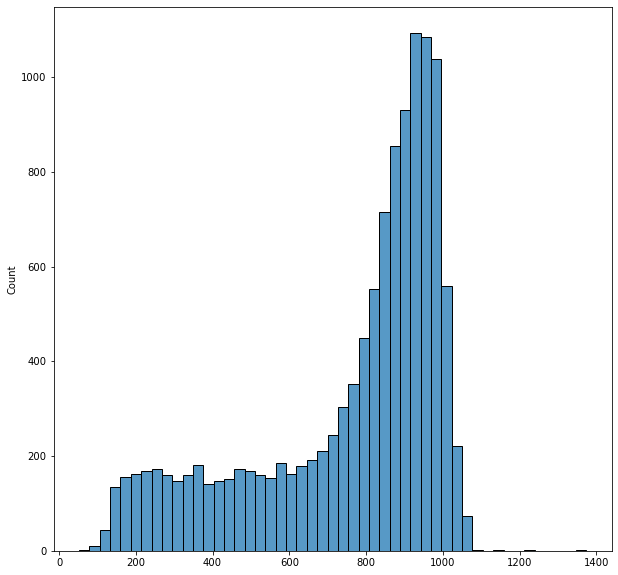

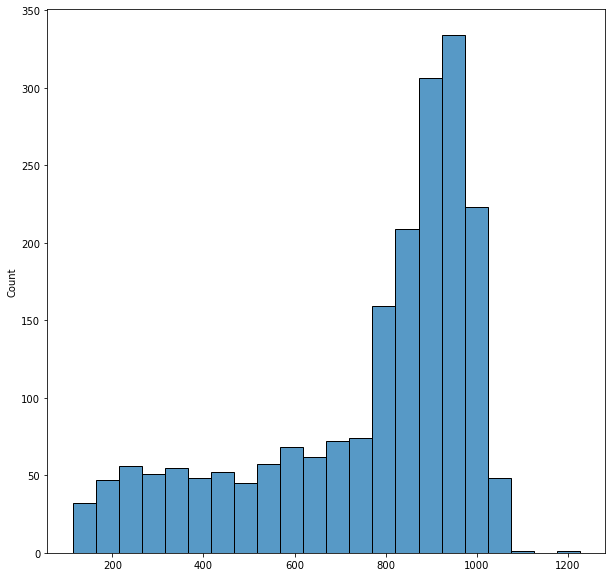

In [13]:
get_data_statistics(train_clean_data)
get_data_statistics(val_clean_data)

# Preparing training in PyTorch

### Training parameters

In [14]:
# batch size for training process
train_batch_size = 64
# batch size for evaluation process
dev_batch_size = 64
# part of train data for progress estimation
dev_part = 0.1
# max number of epochs
nEpochs = 100
# starting learning rate
learning_rate = 0.001
# number of layers in CNN
layers = 15

### We will use PyTorch functionality for batch construction:
  - custom Dataset class to store data with different sizes,
  - customized collate_fn to form batches of different shape elements in DataLoader.

In [15]:
class DetectionDS(Dataset):
    """
    Dataset class.
    Maintains
        data - clean and noisy data
        targets - noise residuals of the same size as noisy or clean data
    """
    def __init__(self, clean, noisy):
        #initialize class object
        
        #concatenate clean and noisy data lists
        self.data = noisy
        #generate corresponding targets
        self.targets = [noisy[i]-clean[i] for i in range(len(clean))]
        
    def __len__(self):
        #standard interface function for Dataset
        if self.data != None:
            return len(self.data)
        
    def __getitem__(self, idx):
        #standard interface function for Dataset
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = [self.data[idx], self.targets[idx]] #{'mel_data': self.data[idx], 'target': self.targets[idx]}
        return sample

In [16]:
def collate_function(batch):
    """
    A customization of default PyTorch collate_fn function
    Forms batch from items of different size:
        looks for min item length and then randomly 
        cuts parts of min length from each item
    """
    #extract data from input batch
    data = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    min_len = 100000
    for elem in data:
        min_len = min(min_len, elem.shape[1])
    
    #slicing data and targets to size of minimum element
    temp_pairs = [random_cut(elem[0], elem[1], min_len) for elem in zip(data, targets)]
    data = [elem[0] for elem in temp_pairs]
    targets = [elem[1] for elem in temp_pairs]
    return [torch.tensor(data).float(), torch.tensor(targets).float()]
        
    
def random_cut(array1, array2, slice_len):
    """
    Help function to randomly cut simultaneously 2 arrays through slicing
    """
    start_cut_range = array1.shape[1] - slice_len
    random_start = np.random.randint(0, start_cut_range+1)

    return (array1[:, random_start: random_start+slice_len], array2[:, random_start: random_start+slice_len])

In [18]:
def coherent_list_shuffle(list1, list2):
    """
    Shuffles 2 lists of the same length in coherent manner
    and returns them.
    It will help us to form random split train data to train and dev datasets
    """
    if len(list1) != len(list2):
        print('Error! Lengths of list1 and list2 must be the same!')
        return -1
    new_order = list(range(len(list1)))
    random.shuffle(new_order)
    new_list1 = [list1[new_order[i]] for i in new_order]
    new_list2 = [list2[new_order[i]] for i in new_order]
   
    return new_list1, new_list2

# l1 = list(range(10))
# l2 = list(range(10))
# l11,l22 = coherent_list_shuffle(l1, l2)
# print(f'{l11}\n{l22}')

In [19]:
def get_DataLoader(clean_data_list, noisy_data_list, batch_size, shuffle=True):
    """
    Returns dataloaders for further training and evaluating
    Input:
        clean_data_list - list of numpy arrays with clean data
        noisy_data_list - list of numpy arrays with noisy data
        batch_size - defines batch size
    """
    dataset = DetectionDS(clean_data_list, noisy_data_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                            collate_fn=collate_function, pin_memory=True)
    return dataloader

In [20]:
train_clean_data, train_noisy_data = coherent_list_shuffle(train_clean_data, train_noisy_data)

In [21]:
dev_data_length = int(len(train_clean_data)*dev_part)
train_data_length = len(train_clean_data) - dev_data_length

train_dataloader = get_DataLoader(train_clean_data[:train_data_length], 
                                  train_noisy_data[:train_data_length],
                                  train_batch_size)
dev_dataloader = get_DataLoader(train_clean_data[train_data_length:], 
                                train_noisy_data[train_data_length:],
                                dev_batch_size)

### Model definition
For noise reduction problem we will use 15-layer DnCNN-like CNN with BatchNorm layers.

In [22]:
class NoiseReductionModel(nn.Module):
    """
    Model definition.
    It is fully-convolutional network, where objective is noise residual part.
    If Y is residual, X is clean data and Y' is noisy data, then CNN output will be 
        Y = Y'- X,
    and accordingly our objective will be computed as 
        X = Y' - Y
    Layers summary:
        There are 20 layers:
            1 Conv1D layer->ReLU,
            18 Conv1D layers->BatchNorm->RelU,
            1 Conv1D layer
    """
    def __init__(self, nLayers=20):
        super(NoiseReductionModel, self).__init__()
        #DnCNN like architecture
        self.repeated_layers = nLayers-2
        self.conv_list = nn.ModuleList()
        for nLayer in range(self.repeated_layers):
            self.conv_list.append(nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1))
            self.conv_list.append(nn.BatchNorm1d(64))
            self.conv_list.append(nn.ReLU())
            if nLayer>0 and nLayer%4==0:
                self.conv_list.append(nn.Dropout(0.5))
        
        self.ConvFirst = nn.Conv1d(in_channels=80, out_channels=64, kernel_size=3, padding=1)
        self.ConvLast = nn.Conv1d(in_channels=64, out_channels=80, kernel_size=3, padding=1)
        
        
    def forward(self, inputs):
        x = F.relu(self.ConvFirst(inputs))
        
        for layer in self.conv_list:
            x = layer(x)
        
        x = self.ConvLast(x)
        
        return x

In [23]:
model = NoiseReductionModel(layers)
model.to(device)
print(model)

NoiseReductionModel(
  (conv_list): ModuleList(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Conv1d(64, 64, kernel_size=

### Auxiliary functions for training epoch and evaluating:

In [24]:
def Train(model, dataloader, device, epoch, learning_rate):
    """
    Computes 1 train epoch.
    Input: 
        model - training model, 
        dataloader - DataLoader with train data,
        device - chosen device,
        epoch - current epoch number
        learning_rate - learning rate for optimizer
    """
    model.train()
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    running_loss = 0.0
    handled_samples = 0
    handled_samples_report_period = 3500
    next_report = handled_samples_report_period
    
    print("Train dataset statistics: ")
    for batch_number, data in enumerate(dataloader):
        samples, targets = data[0], data[1]
        samples, targets = samples.to(device) , targets.to(device)
        epoch_loss = 0
        epoch_acc = 0
        
        # forward + backward + optimize
        model.zero_grad()
        outputs = model(samples)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # print statistics
        handled_samples += targets.shape[0]
        if handled_samples >= next_report:
            print(f'epoch = {epoch:4}, handled samples = {handled_samples:5}, '
                  f'mse_loss = {running_loss/handled_samples:7.6f}')
            next_report += handled_samples_report_period
    
    torch.save(model.state_dict(), f'denoiser_epoch{epoch}.pth')
    return running_loss/handled_samples

In [25]:
def Evaluate(model, dataloader, device):
    """
    Computes output for data in dataloader and returns loss.
    Input: 
        model - trained model, 
        dataloader - DataLoader with evaluating data,
        device - chosen device
    """
    model.eval()
    criterion = nn.MSELoss(reduction='mean')
    running_loss = 0.
    handled_samples = 0
    for batch_number, data in enumerate(dataloader):
        samples, targets = data[0], data[1]
        samples, targets = samples.to(device) , targets.to(device)

        predictions = model(samples)
        targets = targets
        samples = samples
        mel_predictions = samples - predictions
        mel_targets = samples - targets
        
        running_loss += criterion(mel_predictions, mel_targets).item()
        handled_samples += targets.shape[0]
    
    print(f"\nEval dataset statistics: "
          f"eval_mse_loss = {running_loss/handled_samples:7.6f}\n")
    
    return running_loss/handled_samples

# Training classifier:

In [26]:
np.set_printoptions(suppress=True)
cur_learning_rate = learning_rate*0.1
best_model_epoch = 0
no_improve_epochs = 0
no_improve_epochs_to_stop = 3
best_dev_loss = np.Inf

train_losses = []
dev_losses = []

for epoch in range(1, nEpochs+1):
    train_loss = Train(model, train_dataloader, device, epoch, cur_learning_rate)
    dev_loss = Evaluate(model, dev_dataloader, device)
    train_losses.append(train_loss)
    dev_losses.append(dev_loss)
    
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        best_model_epoch = epoch
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs == no_improve_epochs_to_stop:
            print(f'Model stops improving on dev dataset!\n'
                  f'It is early stopping!\n'
                  f"Best model is saved as 'denoiser_epoch{best_model_epoch}.pth'")
            break

Train dataset statistics: 
epoch =    1, handled samples =  3520, mse_loss = 0.003824
epoch =    1, handled samples =  7040, mse_loss = 0.002792
epoch =    1, handled samples = 10560, mse_loss = 0.002342

Eval dataset statistics: eval_mse_loss = 0.001301

Train dataset statistics: 
epoch =    2, handled samples =  3520, mse_loss = 0.001218
epoch =    2, handled samples =  7040, mse_loss = 0.001191
epoch =    2, handled samples = 10560, mse_loss = 0.001143

Eval dataset statistics: eval_mse_loss = 0.001028

Train dataset statistics: 
epoch =    3, handled samples =  3520, mse_loss = 0.001032
epoch =    3, handled samples =  7040, mse_loss = 0.001005
epoch =    3, handled samples = 10560, mse_loss = 0.000989

Eval dataset statistics: eval_mse_loss = 0.000927

Train dataset statistics: 
epoch =    4, handled samples =  3520, mse_loss = 0.000929
epoch =    4, handled samples =  7040, mse_loss = 0.000907
epoch =    4, handled samples = 10560, mse_loss = 0.000918

Eval dataset statistics: ev

<AxesSubplot:title={'center':'TRAIN vs DEV losses'}, xlabel='epochs', ylabel='loss value'>

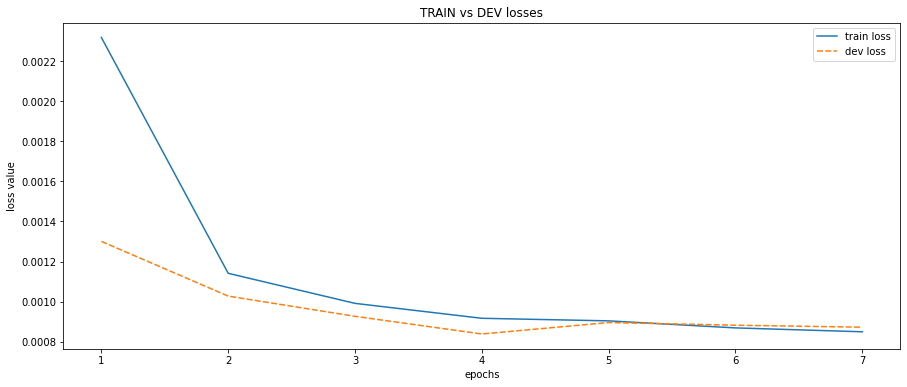

In [27]:
plot_df = pd.DataFrame({'train loss':train_losses, 'dev loss': dev_losses}, index = range(1, len(train_losses)+1))
plt.figure(figsize=(15,6))
plt.title(f'TRAIN vs DEV losses')
plt.xlabel('epochs')
plt.ylabel('loss value')
sns.lineplot(data=plot_df)

# Denoising evaluation
Loading best trained model and compute its loss

In [29]:
loaded_denoising_model = NoiseReductionModel(layers)
# model_state_dict = torch.load(f'denoiser_epoch{best_model_epoch}.pth')
model_state_dict = torch.load(f'denoiser_epoch{best_model_epoch}.pth')
loaded_denoising_model.load_state_dict(model_state_dict)
loaded_denoising_model.to(device);

In [30]:
val_dataloader = get_DataLoader(val_clean_data, val_noisy_data, batch_size=1, shuffle=False)

In [31]:
val_loss = Evaluate(loaded_denoising_model, val_dataloader, device)


Eval dataset statistics: eval_mse_loss = 0.054880



In [32]:
def EvaluateAndVisualize(model, clean_data, noisy_data, device, list_of_indeces_to_check):
    """
    Computes output for data of certain indeces, returns loss and draw heatmaps of data.
    Input: 
        model - trained model,
        clean_data - clean data,
        noisy_data - noisy data,
        device - chosen device,
        list_of_indeces_to_check - list of indeces of data to compute loss and draw figures
    """
    model.eval()
    dataset = DetectionDS(clean_data, noisy_data)
    criterion = nn.MSELoss(reduction='mean')

    for data_idx in list_of_indeces_to_check:
        data = dataset[data_idx]
        sample, target = torch.tensor(data[0]).unsqueeze(0).float(), torch.tensor(data[1]).unsqueeze(0).float()
        sample, target = sample.to(device) , target.to(device)

        prediction = model(sample)
        mel_prediction = sample - prediction
        mel_target = sample - target
        
        loss = criterion(mel_prediction, mel_target).item()
        
        sample = sample.squeeze(0).cpu().detach().numpy()
        mel_prediction = mel_prediction.squeeze(0).cpu().detach().numpy()
        mel_target = mel_target.squeeze(0).cpu().detach().numpy()
        print(f'mel-spectrogram idx={data_idx}, loss={loss:5.3}\n')
        
        plt.figure(figsize=(15,15))
        plt.subplot(311)
        plt.title(f'Noisy sample_{data_idx}')
        sns.heatmap(sample, cmap="YlGnBu")
        plt.subplot(312)
        plt.title(f'Predicted sample_{data_idx}')
        sns.heatmap(mel_prediction, cmap="YlGnBu")
        plt.subplot(313)
        plt.title(f'Clean sample_{data_idx}')
        sns.heatmap(mel_target, cmap="YlGnBu")
        pass

mel-spectrogram idx=10, loss=0.0402

mel-spectrogram idx=17, loss=0.036

mel-spectrogram idx=32, loss=0.0402



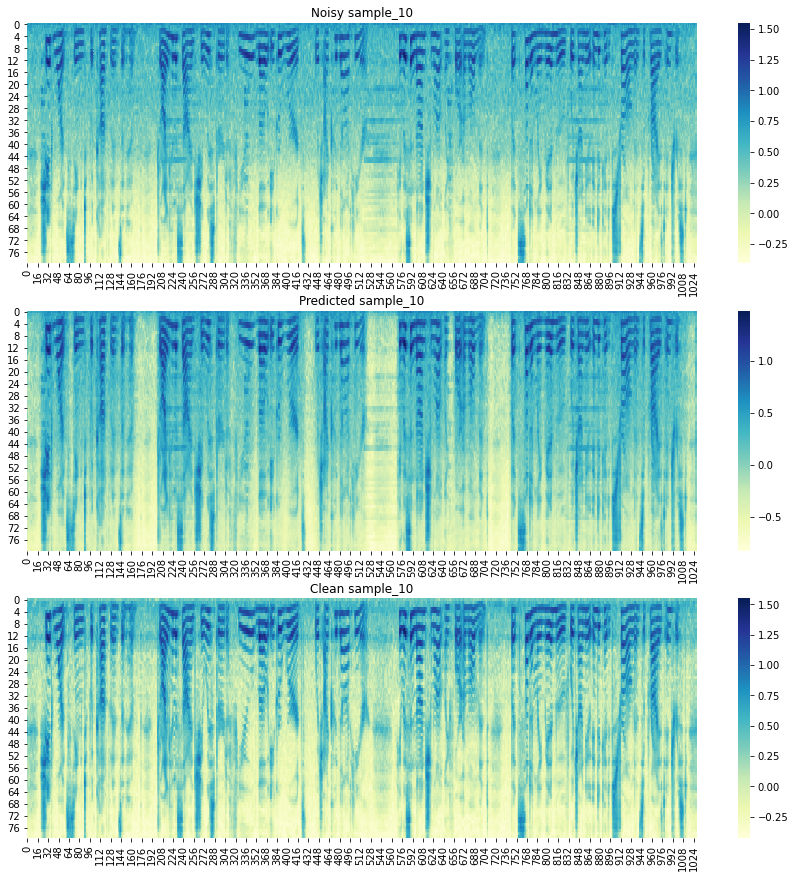

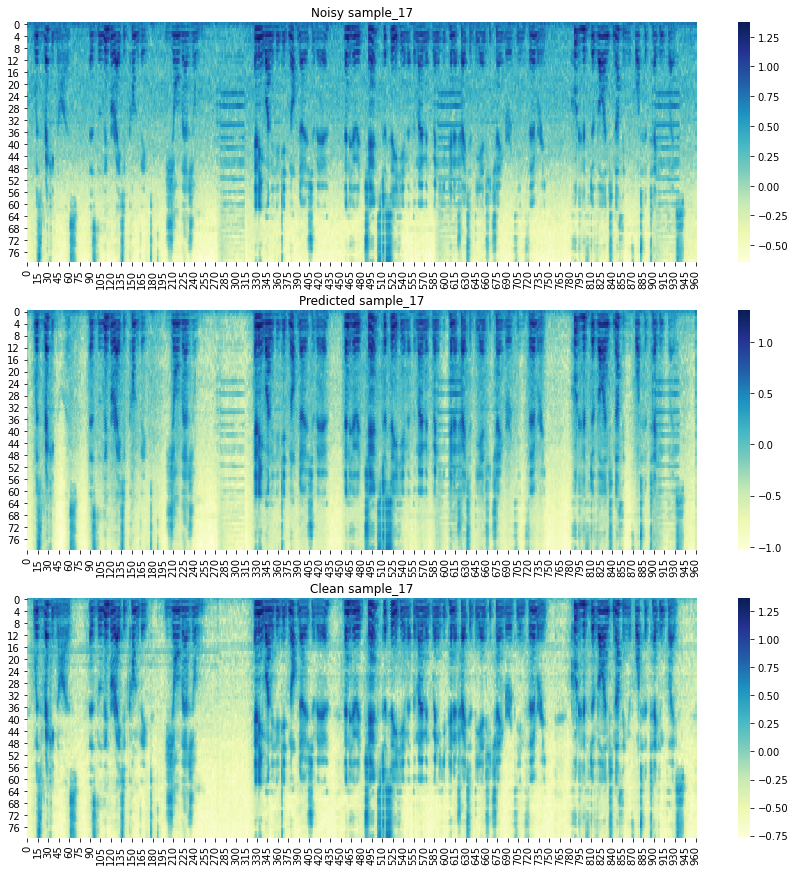

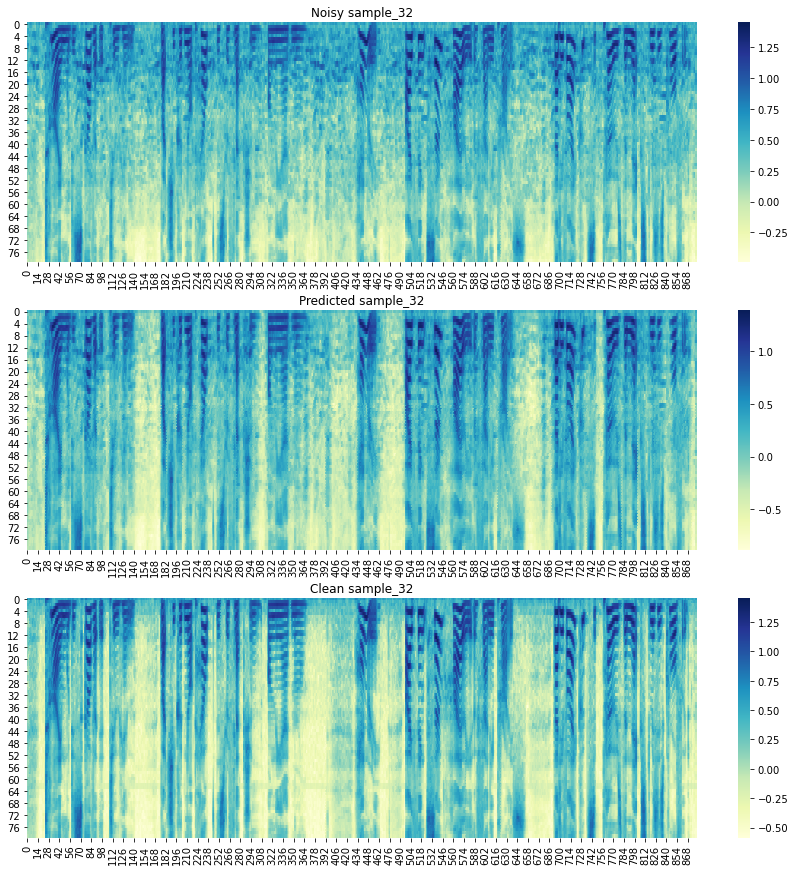

In [33]:
EvaluateAndVisualize(loaded_denoising_model, val_clean_data, val_noisy_data, device, [10,17,32])